In [47]:
# standard imports
import pandas as pd
import numpy as np
import math

# prepare + acquire
from acquire_b import get_zillow_data
import prepare_b
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# exploration / visualization
import seaborn as sns
import matplotlib.pyplot as plt

# hypotheses testing
import scipy.stats as stats

# Acquire

In [2]:
# use the function to grab the data from SQL
zillow = get_zillow_data()
zillow.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,parcelid.1,logerror,transactiondate,propertylandusetypeid.1,propertylandusedesc
0,1248,17305333,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,212.46,NaN,NaN,6.111002e+13,1248,11289917,-0.362001,2017-06-23,263,Mobile Home
1,1772,10838338,NaN,NaN,NaN,2.0,4.0,NaN,6.0,2.0,...,6089.82,NaN,NaN,6.037128e+13,1772,11705026,-0.146056,2017-06-30,261,Single Family Residential
2,2028,10901531,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,6679.55,NaN,NaN,6.037125e+13,2028,14269464,0.021085,2017-06-01,261,Single Family Residential
3,3273,11262089,1.0,NaN,NaN,2.0,3.0,NaN,8.0,2.0,...,3876.31,NaN,NaN,6.037901e+13,3273,11389003,-0.325393,2017-06-01,261,Single Family Residential
4,3429,11323134,NaN,NaN,NaN,2.0,2.0,NaN,6.0,2.0,...,4206.15,NaN,NaN,6.037901e+13,3429,11967869,-0.005566,2017-06-29,261,Single Family Residential


In [3]:
# summarize
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19667 entries, 0 to 19666
Data columns (total 65 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            19667 non-null  int64  
 1   parcelid                      19667 non-null  int64  
 2   airconditioningtypeid         5759 non-null   float64
 3   architecturalstyletypeid      28 non-null     float64
 4   basementsqft                  5 non-null      float64
 5   bathroomcnt                   19667 non-null  float64
 6   bedroomcnt                    19667 non-null  float64
 7   buildingclasstypeid           0 non-null      float64
 8   buildingqualitytypeid         14715 non-null  float64
 9   calculatedbathnbr             19292 non-null  float64
 10  decktypeid                    85 non-null     float64
 11  finishedfloor1squarefeet      961 non-null    float64
 12  calculatedfinishedsquarefeet  19505 non-null  float64
 13  f

# Prepare

In [4]:
#COME BACK AFTER MVP

# filter all of the relevant data with a mask

#column_filter = (zillow.isnull().sum() < 18000)
#columns_to_keep = zillow.columns[column_filter]
#df = zillow[columns_to_keep]
#zillow[columns_to_keep].isnull()

In [5]:
# create a dataframe from prepare file
df = prepare_b.prep_zillow()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19299 entries, 0 to 19666
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bathroomcnt        19299 non-null  float64
 1   bedroomcnt         19299 non-null  int64  
 2   zipcode            19299 non-null  int64  
 3   taxamount          19299 non-null  float64
 4   taxvaluedollarcnt  19299 non-null  float64
 5   yearbuilt          19299 non-null  int64  
 6   sqft               19299 non-null  int64  
 7   county             19299 non-null  object 
 8   tax_rate           19299 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 1.5+ MB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bathroomcnt,19299.0,2.210684,0.988779,0.00,2.000,2.00,3.00,20.00
bedroomcnt,19299.0,3.072646,1.009545,0.00,2.000,3.00,4.00,25.00
zipcode,19299.0,96495.213742,3800.436448,95982.00,96150.000,96339.00,96533.00,399675.00
taxamount,19299.0,5444.767672,6941.795704,37.65,2476.985,3963.20,6166.21,228999.21
taxvaluedollarcnt,19299.0,444348.848075,598080.920018,3257.00,184092.000,313848.00,510435.00,19129816.00
yearbuilt,19299.0,1962.409296,22.921862,1862.00,1949.000,1960.00,1979.00,2015.00
sqft,19299.0,1743.394062,938.396722,60.00,1180.000,1520.00,2038.00,26345.00
tax_rate,19299.0,1.321326,0.355193,0.00,1.190,1.24,1.35,15.51


In [7]:
df.zipcode.nlargest(5)

6954    399675
6955    399675
6956    399675
1408     97344
1409     97344
Name: zipcode, dtype: int64

In [8]:
(df.zipcode == 99675).sum()

0

In [11]:
# Use split function to create train, validate, and test dfs
train, validate, test = prepare_b.zillow_split(df)

train.shape, validate.shape, test.shape

((10807, 9), (4632, 9), (3860, 9))

In [13]:
# Split into X and y data frames
X_train = train.drop(columns=['taxvaluedollarcnt'])
X_validate = validate.drop(columns=['taxvaluedollarcnt'])
X_test = test.drop(columns=['taxvaluedollarcnt'])

y_train = train[['taxvaluedollarcnt']]
y_validate = validate[['taxvaluedollarcnt']]
y_test = test[['taxvaluedollarcnt']]

In [17]:
# Create scaler object
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(copy=True).fit(X_train.drop(columns='county'))

X_train_scaled = scaler.transform(X_train.drop(columns='county'))
X_validate_scaled = scaler.transform(X_validate.drop(columns='county'))
X_test_scaled = scaler.transform(X_test.drop(columns='county'))

In [15]:
#train, validate, test = prepare_b.add_scaled_columns(train, validate, test, scaler, 
                                          # train.drop(columns=['taxvaluedollarcnt', 'county', 'zipcode']).columns)
train.head()

,bathroomcnt,bedroomcnt,zipcode,taxamount,taxvaluedollarcnt,yearbuilt,sqft,county,tax_rate
2459,2.0,2,96005,8378.08,693537.0,1987,1442,Los Angeles County,1.21
7559,2.0,4,96186,3031.24,260222.0,1956,1355,Orange County,1.16
17309,4.0,3,96293,11502.36,993231.0,1979,3328,Los Angeles County,1.16
12096,1.0,3,97113,2580.04,239884.0,1930,1412,Ventura County,1.08
19197,2.0,4,96122,1643.98,109506.0,1973,2100,Los Angeles County,1.50


In [ ]:
# Use function to add scaled columns to dataframe
train, validate, test = prepare_b.add_scaled_columns(train, validate, test, scaler, 
                                           train.drop(columns=['taxvaluedollarcnt', 'county', 'zipcode']).columns)

train.info()

# Exploration

In [18]:
# plt rc sets defaults for matplotlib figures
plt.rc("font", size=13)
plt.rc("figure", figsize= (13,7))

In [19]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
bathroomcnt,10807.0,2.217082,1.002414,0.00,2.00,2.00,3.00,20.00
bedroomcnt,10807.0,3.082261,1.016788,0.00,2.00,3.00,4.00,25.00
zipcode,10807.0,96474.678357,2942.814998,95982.00,96150.00,96337.00,96531.00,399675.00
taxamount,10807.0,5447.543364,6789.625921,37.65,2484.94,3975.00,6260.51,228999.21
taxvaluedollarcnt,10807.0,445075.393726,596302.437180,3257.00,183981.00,313003.00,518000.00,19129816.00
yearbuilt,10807.0,1962.271121,23.010068,1885.00,1949.00,1960.00,1979.00,2015.00
sqft,10807.0,1754.387434,951.757552,172.00,1183.00,1532.00,2061.00,26345.00
tax_rate,10807.0,1.324333,0.384850,0.00,1.19,1.24,1.36,15.51


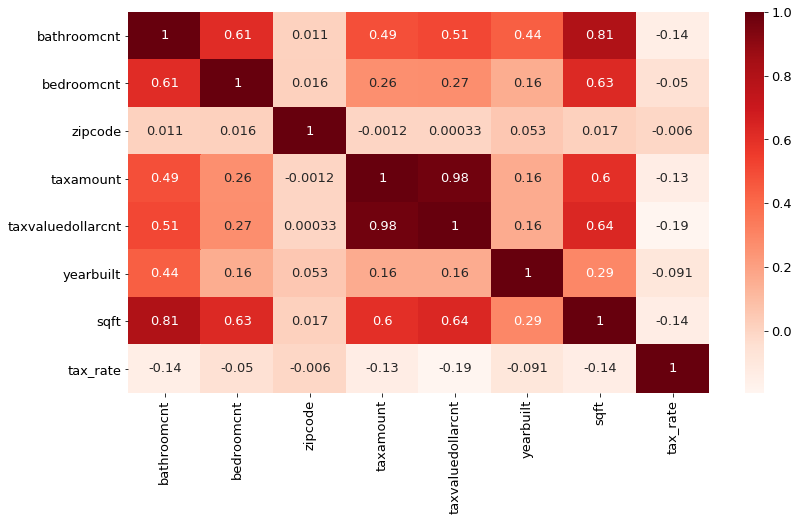

In [20]:
# looking at correlation for all variables
sns.heatmap(train.corr(), cmap='Reds', annot=True)

Text(0.5, 1.0, 'Tax Value Distribution per Bedroom')

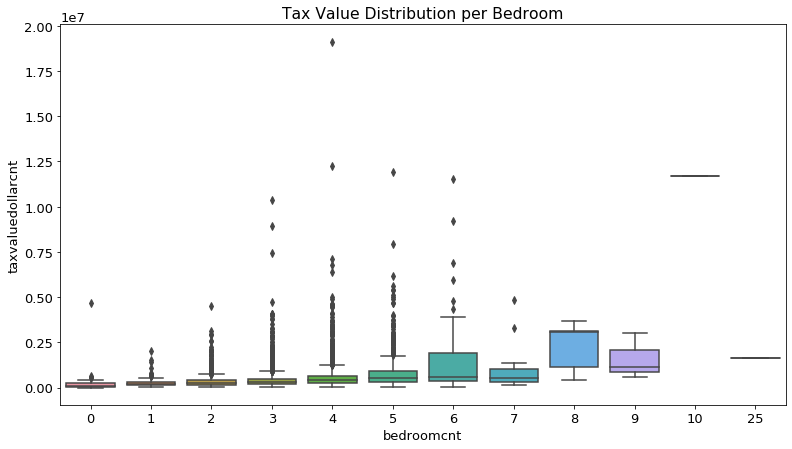

In [35]:
sns.boxplot(data=train, y='taxvaluedollarcnt', x='bedroomcnt')
plt.title('Tax Value Distribution per Bedroom')


Text(0.5, 1.0, 'Tax Rate per County')

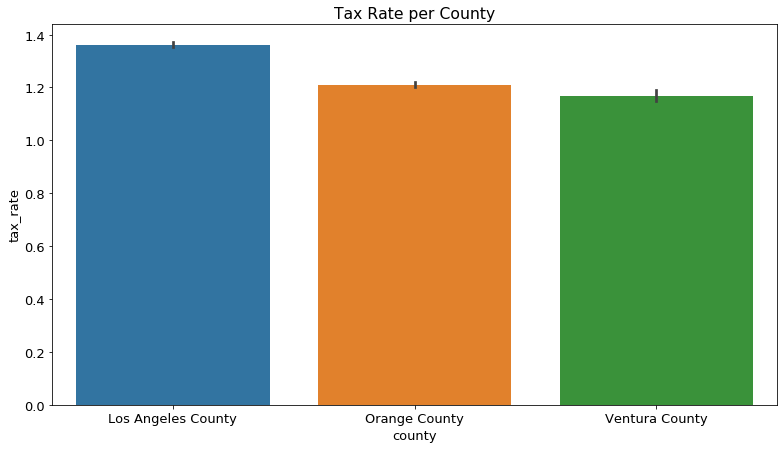

In [24]:
sns.barplot(data=train, y='tax_rate', x='county')
plt.title('Tax Rate per County')

Text(0.5, 1.0, 'Count of Single Unit Homes in each County')

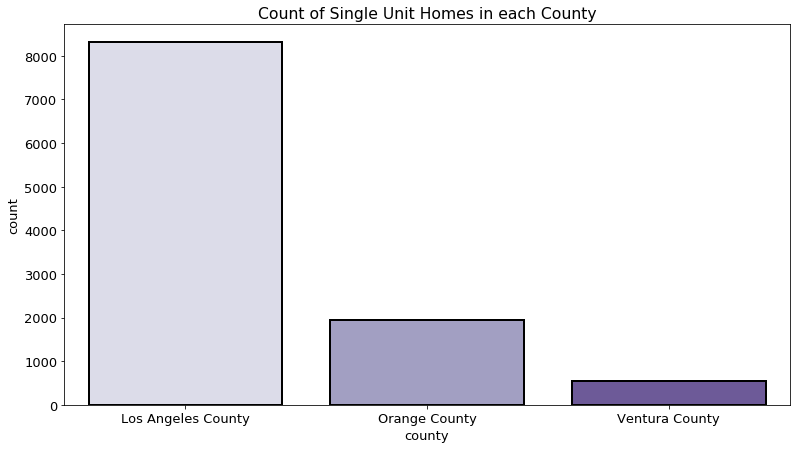

In [37]:
sns.countplot(x = 'county', data=train, palette='Purples', ec='black', linewidth=2)
plt.title('Count of Single Unit Homes in each County')

## Hypothesis Tests

### One Sample Single-Tailed T-Test

Text(0.5, 1.0, 'Distribution of Population Home Values')

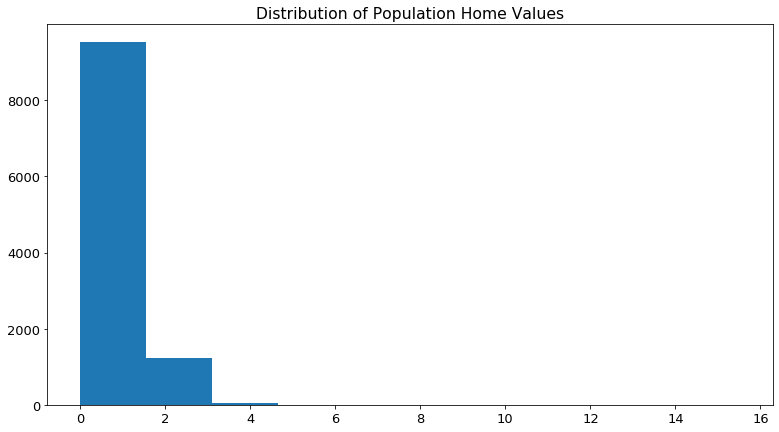

In [59]:
plt.hist(train.tax_rate)
plt.title('Distribution of Population Home Values')

Text(0.5, 1.0, 'Distribution of LA County Home Values')

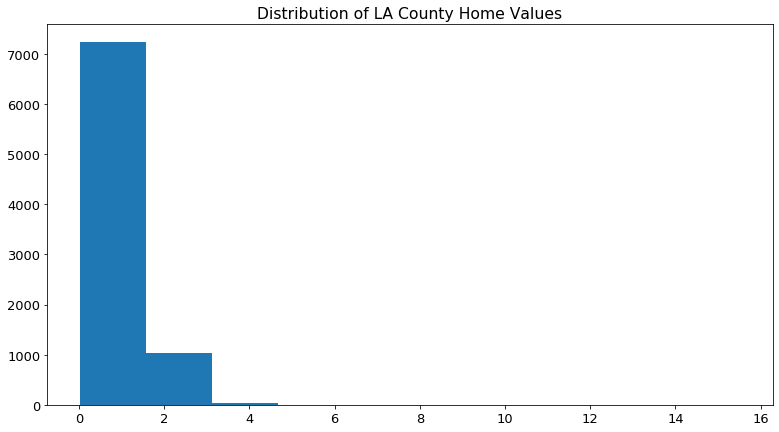

In [60]:
plt.hist(train.tax_rate[train.county == 'Los Angeles County'])
plt.title('Distribution of LA County Home Values')

**Hypotheses**

$H_0$: mean tax rate Value Los Angeles County <= the overall population of assessed counties
$H_a$: mean tax rate Los Angeles County > the overall population of assessed counties

In [66]:
null = 'Mean tax rate Value Los Angeles County <= the overall population of assessed counties'

# set a significance level
alpha = .05

# verify assumptions
train.county.value_counts()

Los Angeles County    8308
Orange County         1943
Ventura County         556
Name: county, dtype: int64

**Compute T-Statistic and P-Value**

In [64]:
overall_mean = train.tax_rate.mean()
sample_mean = train.tax_rate[train.county == 'Los Angeles County']

t, p = stats.ttest_1samp(sample_mean, overall_mean)
print('T-statistic: ', t)
print('P-value: ', p/2)

T-statistic:  8.198682809635814
P-value:  1.3967412741375902e-16


**Decision**

In [69]:
if p/2 > alpha:
    print("We fail to reject $H_{0}$ that", null)
elif t < 0:
    print("We fail to reject H_{0}$ that", null)
else:
    print("We reject H_0 that", null)

We reject \$H_0$ that Mean tax rate Value Los Angeles County <= the overall population of assessed counties


### Correlation Test

### *need to get rid of outliers in bedroomcnt/bathroomcnt*